# Reservoir Code

In [1]:
%pip install reservoirpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 202.5/202.5 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 8.0 MB/s eta 0:00:00


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
from math import comb
import time
from tabulate import tabulate
from reservoirpy.datasets import lorenz

ModuleNotFoundError: No module named 'reservoirpy'

In [ ]:
##### CONSTANTS #####

number_of_features = 3
reservoir_dim = 300
edge_creation_prob = 0.1
spectral_radius = 1.2

train_test_split_ratio = 0.9
n_timesteps = 5000

sigma, rho, beta, h = 10, 28, 8/3, 0.02

In [ ]:
##### DATASET #####

def dataset(n_timesteps):
    training_split = train_test_split_ratio
    n_timesteps = n_timesteps
    data = lorenz(n_timesteps=n_timesteps, sigma=sigma, rho=rho, beta=beta, h=h)
    training_data = np.array(data[:int(n_timesteps*training_split)])
    testing_data = np.array(data[int(n_timesteps*training_split):])

    return data, training_data, testing_data

In [ ]:
##### RESERVOIR SYSTEM #####

def create_system(output_dim, reservoir_dim, spectral_radius, edge_creation_prob, seed, graph_type, random_edge_probability):

  reservoir = np.zeros(reservoir_dim)
  reservoir_input = (np.random.rand(reservoir_dim, output_dim) - .5) * edge_creation_prob

  if graph_type == 'default':
    if not random_edge_probability:
      graph = nx.gnp_random_graph(reservoir_dim, edge_creation_prob, seed)
    else:

      graph = nx.Graph()
      for i in range(reservoir_dim):
        graph.add_node(i)

      i = 0
      num_edges_prob = comb(reservoir_dim, 2) * 0.5
      while True:
        if i >= num_edges_prob:
          break
        node1 = np.random.randint(0, reservoir_dim)
        node2 = np.random.randint(0, reservoir_dim)
        while node2 == node1:
          node2 = np.random.randint(0, reservoir_dim)
        if node1 not in graph[node2]:
          probability = np.random.uniform(0, 1)
          val = np.random.randint(0, 1000000000)
          if val < probability * 1000000000:
            graph.add_edge(node1, node2)
            graph.add_edge(node2, node1)
            i += 1

  elif graph_type == 'complete':
    graph = nx.complete_graph(reservoir_dim)

  elif graph_type == 'tree':
    graph = nx.random_powerlaw_tree(reservoir_dim, seed=seed, tries=reservoir_dim* 1000)

  graph = nx.to_numpy_array(graph)

  rand_mat = 2 * (np.random.rand(reservoir_dim, reservoir_dim) - 0.5)
  scale_mat = graph * rand_mat
  ev = np.linalg.eig(scale_mat)[0]
  max_ev = np.max(ev)
  rescale_mat = scale_mat/np.absolute(max_ev) * spectral_radius

  return rescale_mat, reservoir, reservoir_input

def fit(data, output_dim, reservoir_dim, reservoir, adj, reservoir_input):

  reservoir_output = np.zeros((output_dim, reservoir_dim))
  state_matrix = np.zeros((reservoir_dim, data.shape[0]))

  for time_step in range(data.shape[0]):
      np.put(state_matrix[:, time_step], range(len(state_matrix)), reservoir)
      x = np.dot(adj, reservoir) + np.dot(reservoir_input, data[time_step])

      reservoir = np.tanh(x)

  transposed_matrix = np.transpose(state_matrix)
  identity_matrix = 0.0001 * np.identity(state_matrix.shape[0])
  inverse_part = np.linalg.solve(np.dot(state_matrix, transposed_matrix) + identity_matrix, np.eye(state_matrix.shape[0]))
  reservoir_output = np.dot(np.dot(data.T, transposed_matrix), inverse_part)

  return reservoir, reservoir_output

def forecast(future_data, output_dim, reservoir, adj, reservoir_input, reservoir_output):
  pred = np.zeros((future_data, output_dim))
  for time_step in range(future_data):
      pred[time_step] = np.dot(reservoir_output, reservoir)
      x = np.dot(adj, reservoir) + np.dot(reservoir_input, pred[time_step])
      reservoir = np.tanh(x)
  return pred

def create_fit_forecast(output_dim, reservoir_dim, scaler, edge_creation_prob, seed, graph_type="default",
                        random_edge_probability=False, data=None, future_data=None):

  adj, reservoir, reservoir_input = create_system(output_dim, reservoir_dim, scaler, edge_creation_prob, seed, graph_type, random_edge_probability)

  if data is None: return adj, reservoir, reservoir_input
  else: reservoir, reservoir_output = fit(data, output_dim, reservoir_dim, reservoir, adj, reservoir_input)

  if future_data is None: return adj, reservoir, reservoir_input, reservoir_output
  else: preds = forecast(future_data, output_dim, reservoir, adj, reservoir_input, reservoir_output)

  return preds

In [ ]:
##### OTHER METHODS #####

def average_forecast_horizon(preds, actual):
  s = np.std(actual)
  x, y, z = 0, 0, 0
  for i, vals in enumerate(preds):
    x += (preds[i][0] - actual[i][0]) < s
    y += (preds[i][1] - actual[i][1]) < s
    z += (preds[i][2] - actual[i][2]) < s
  return x/len(preds), y/len(preds), z/len(preds)

def getAccuracy(predicted_data, testing_data):
  return average_forecast_horizon(predicted_data, testing_data)

def makeAndSaveGraph(test, pred, title=None):
  fig, ax = plt.subplots(3, 1, figsize=(9, 9))
  t = [i for i in range(trainLength, n_timesteps)]
  temp = ['X', 'Y', 'Z']
  color_table = ['red', 'green', 'blue']
  if title:
    ax[0].set_title(title+'\n')
  for i in range(3):
    if i == 0:
      new_title = title + '\n' + "Predicted Lorenz " + temp[i] + " Data and Actual Lorenz " + temp[i] + " Data"
    else:
      new_title = "Predicted Lorenz " + temp[i] + " Data and Actual Lorenz " + temp[i] + " Data"
    ax[i].set_title(new_title)
    ax[i].set_xlabel("timestep")
    ax[i].plot(t, test[:, i], label=temp[i], color=color_table[i])
    ax[i].plot(t, pred[:, i], label=temp[i]+"_pred")
    ax[i].legend()

  fig.tight_layout()

  plt.show(title + ".jpg")

#Changed Run Code

In [ ]:
#New Constants

n_timesteps = 5000
trainLength = 4500
testLength = 500
seed = 69

number_of_features = 3
reservoir_dim = 300
edge_creation_prob = 0.1
spectral_radius = 1.2

sigma, rho, beta, h = 10, 28, 8/3, 0.02

In [ ]:
data,_,_ = dataset(n_timesteps)

In [ ]:
training_data = data[0:trainLength,:]
test_data = data[trainLength:,:]
print(training_data.shape)
print(test_data.shape)

(495000, 3)
(5000, 3)


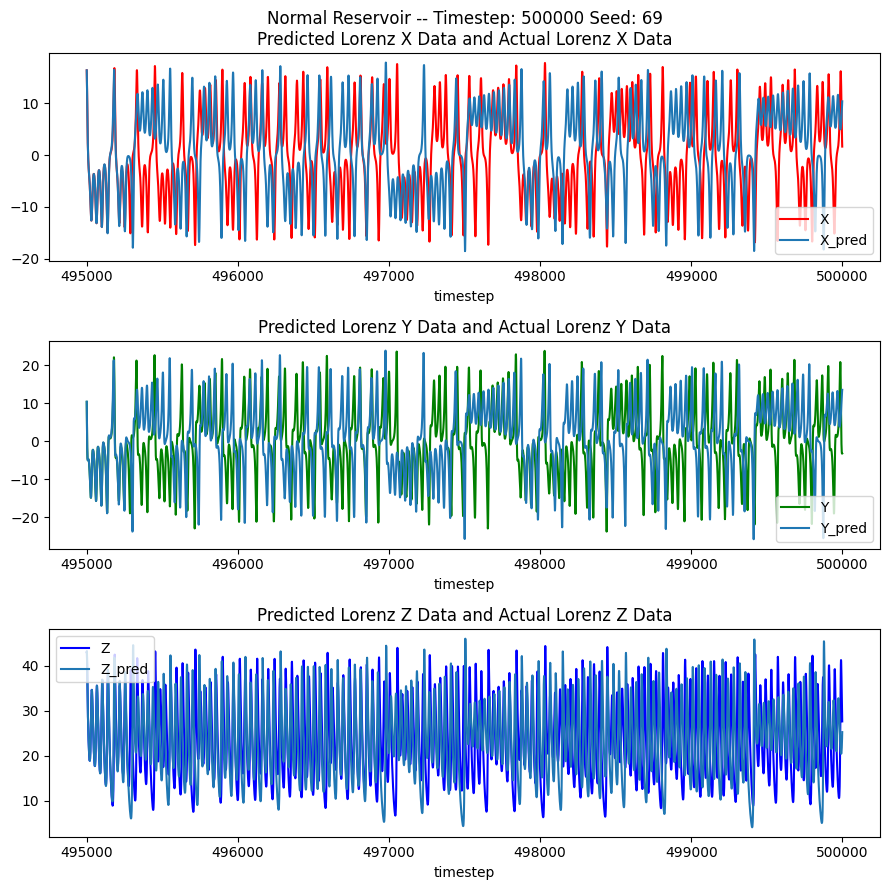

In [ ]:
# Model 1
predicted_data = create_fit_forecast(number_of_features, reservoir_dim, spectral_radius, edge_creation_prob,
                                      seed=seed, data=training_data, future_data=len(test_data))
accuracy1 = getAccuracy(predicted_data, test_data)
makeAndSaveGraph(test_data, predicted_data, title = "Normal Reservoir -- Timestep: " + str(n_timesteps) + " Seed: " + str(seed))


In [ ]:
print(predicted_data.shape)

(5000, 3)
